In [1]:
import os
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display

from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error

### Load and transform input dataset

Input dataset consists of description feature and points target variable.

Data will be loaded into pandas dataframe and split into train and test subsets.

Description feature will be encoded with TF-IDF encoder while points target variable will be normalized or standardized based on user input.

In [2]:
path_v1 = "./Data/winemag-data-130k-v2.csv" 
path_v2 = "./Data/winemag-data_first150k.csv"
col_idx = 0
train_size, test_size = 0.8, 0.2
max_features = 100
# ngram_range for CountVectorizer
ngram_range=(1, 2)
columns = ['description', 'points']
transform_target = 'normalize'

In [3]:
def load_data(path_v1: str, path_v2: str, columns: list, col_idx: int):
  """
  Load and concatenate two datasets with removing duplicates.
  param path_v1: import path of first dataset
  param path_v2: import path of second dataset
  param columns: list of columns to preserve in dataframe
  param col_idx: index of column given in input columns list 
                 on which look for duplicates in dataframe
  return:        pandas dataframe
  """
  
  df_v1 = pd.read_csv(path_v1, index_col=0)
  df_v1 = df_v1[columns]
    
  # remove numbers form column description from first dataframe
  df_v1.description = df_v1.description.str.replace('\d+', '')

  df_v2 = pd.read_csv(path_v2, index_col=0)
  df_v2 = df_v2[columns]
    
  # remove numbers form column description from second dataframe
  df_v2.description = df_v2.description.str.replace('\d+', '')

  df = pd.concat([df_v1, df_v2])

  # dropping duplicte values
  df.drop_duplicates(subset = columns[col_idx],
                       keep = 'first', inplace = True)
  
  return df

In [4]:
def split_data(df: pd.DataFrame, train_size: float, test_size: float):
  """
  Split dataset on train, test and validation subsets.
  param df:          input dataframe
  param train_size:  fraction of train size
  param test_size:   fraction of test size
  return:            dictionary, keys=names of dataframes, columns=dataframes
  """
  
  # shuffle dataset
  df = df.sample(frac = 1)
  
  # split on test and train set
  text_train, text_test, y_train, y_test = train_test_split(df.description, df.points,
                                           test_size=test_size, train_size=train_size)
  
  y_train, y_test = y_train.astype('float'), y_test.astype('float')

  dataset_dict = {
      'text_train': text_train,
      'y_train': y_train,
      'text_test': text_test,
      'y_test': y_test
  }

  return dataset_dict

In [12]:
def transform_data(df_data: dict, transform: str, max_features: int, ngram_range: tuple):
    """
    Encode input textual features and transform continuus target variable (standardization, normalization).
    param df_data:      dictionary, keys=names of dataframes, columns=dataframes
    param transform:    name of the target variable transformation
    param max_features: use best num of features
    param ngram_range:  the lower and upper boundary of the range of n-values for different 
                        word n-grams or char n-grams to be extracted. For example an ngram_range of (1, 1) means only unigrams, 
                        (1, 2) means unigrams and bigrams, and (2, 2) means only bigrams.
    return:             dictionary, keys=names transformed data and scaler, columns=transformed data and scaler object
    """
    # vectorize input text to numerical features
    count_vect = CountVectorizer(max_features=max_features, stop_words='english')
    
    df_train = count_vect.fit_transform(df_data['text_train'])

    df_test = count_vect.fit_transform(df_data['text_test'])
    
    # apply tf-idf transform
    tf_transformer = TfidfTransformer(use_idf=True).fit(df_train)
    
    df_train_encode = tf_transformer.transform(df_train)

    df_test_encode = tf_transformer.transform(df_test)
    
    df_data['y_train'] = df_data['y_train'].to_numpy().reshape(-1, 1)
    df_data['y_test'] = df_data['y_test'].to_numpy().reshape(-1, 1)
    
    # apply target variable transformation
    if transform == 'normalize':
        scaler = MinMaxScaler()
        scaler.fit(df_data['y_train'])
        train_y = scaler.transform(df_data['y_train'])
        test_y = scaler.transform(df_data['y_test'])
    
    elif transform == 'standardize':
        scaler = StandardScaler()
        scaler.fit(df_data['y_train'])
        train_y = scaler.transform(df_data['y_train'])
        test_y = scaler.transform(df_data['y_test'])
    
    else:
        raise ValueError("Transform of target variable wrong specified. Please choose between normalize or standardize transforms.")
    
    train_y, test_y = train_y.ravel(), test_y.ravel()
    
    transformed_data = {
        'text_train': df_train_encode.todense(),
        'y_train': train_y,
        'text_test': df_test_encode.todense(),
        'y_test': test_y,
        'scaler': scaler
    }
    
    return transformed_data

In [6]:
# call data transformation functions
df = load_data(path_v1, path_v2, columns, col_idx)
df_data = split_data(df, train_size, test_size)
transformed_data = transform_data(df_data, transform_target, max_features, ngram_range)

In [7]:
transformed_data['text_train']

matrix([[0.        , 0.29907753, 0.        , ..., 0.12199621, 0.        ,
         0.26771974],
        [0.        , 0.        , 0.        , ..., 0.1728586 , 0.        ,
         0.        ],
        [0.25859916, 0.        , 0.        , ..., 0.18155927, 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.13827813, 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.38189009, 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.14322813, 0.        ,
         0.        ]])

### Hyparameters tuning

Hyperparamethers tuning wil be made for RandomForestRegressor and GradientBoostingRegressor algorithms on a give input TF-IDF features and normalized target points variable.

In [8]:
def get_best_params(model, tuned_parameters, X_train, Y_train):
    """
    Calculate cross validation score for different set of hyper parameters.
    param model:             regression model
    param tuned_parameters:  dict of tuning parameters for specified ML model
    param X_train:           input features, pandas dataframe
    param Y_train:           target continuus variable, pandas series
    """
    
    print("# Tuning hyper-parameters! ")
    print()

    clf = RandomizedSearchCV(estimator = model, param_distributions = tuned_parameters, cv = 3, n_jobs = -1)
    clf.fit(X_train, Y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
                % (mean, std * 2, params))
    print()
    
    return clf.best_params_


In [11]:

models = {
    'gb': GradientBoostingRegressor(),
    'rf': RandomForestRegressor()
}

# Create the random grid
gb_params = {  
               'loss': ['huber'],
               'learning_rate': [0.1, 0.01],
               'n_estimators': [50, 100, 150, 200],
               'max_features': ['auto', 'sqrt'],
               'max_depth': [3, 6, 9]
           }

rf_params = {   
               'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 500, num = 50)],
               'max_features': ['auto', 'sqrt'],
               'max_depth': [int(x) for x in np.linspace(10, 100, num = 20)],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]
           }


Get best params for GradientBoostingRegressor model.

In [10]:
best_params = get_best_params(models['gb'], gb_params, transformed_data['text_train'], transformed_data['y_train'])

# Tuning hyper-parameters! 

Best parameters set found on development set:

{'n_estimators': 200, 'max_features': 'auto', 'max_depth': 9, 'loss': 'huber', 'learning_rate': 0.1}

Grid scores on development set:

0.246 (+/-0.002) for {'n_estimators': 200, 'max_features': 'sqrt', 'max_depth': 6, 'loss': 'huber', 'learning_rate': 0.01}
0.181 (+/-0.002) for {'n_estimators': 100, 'max_features': 'auto', 'max_depth': 6, 'loss': 'huber', 'learning_rate': 0.01}
0.388 (+/-0.003) for {'n_estimators': 200, 'max_features': 'auto', 'max_depth': 9, 'loss': 'huber', 'learning_rate': 0.1}
0.265 (+/-0.002) for {'n_estimators': 150, 'max_features': 'auto', 'max_depth': 9, 'loss': 'huber', 'learning_rate': 0.01}
0.294 (+/-0.003) for {'n_estimators': 200, 'max_features': 'auto', 'max_depth': 9, 'loss': 'huber', 'learning_rate': 0.01}
0.352 (+/-0.002) for {'n_estimators': 200, 'max_features': 'auto', 'max_depth': 3, 'loss': 'huber', 'learning_rate': 0.1}
0.225 (+/-0.002) for {'n_estimators': 150, 'max_featu

Get best params for RandomForestRegressor model.

In [13]:
best_params_rf = get_best_params(models['rf'], rf_params, transformed_data['text_train'], transformed_data['y_train'])

# Tuning hyper-parameters! 

Best parameters set found on development set:

{'n_estimators': 426, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 66, 'bootstrap': True}

Grid scores on development set:

-0.111 (+/-0.021) for {'n_estimators': 255, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 66, 'bootstrap': False}
0.246 (+/-0.004) for {'n_estimators': 410, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 10, 'bootstrap': True}
0.381 (+/-0.003) for {'n_estimators': 491, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 81, 'bootstrap': False}
0.362 (+/-0.003) for {'n_estimators': 426, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 95, 'bootstrap': True}
0.342 (+/-0.004) for {'n_estimators': 255, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 28, 'bootstrap': True}
0.383 (

### Train

#### Train GradientBoostingRegressor with best params

In [14]:
gb = GradientBoostingRegressor(**best_params)
gb.fit(transformed_data['text_train'], transformed_data['y_train'])

GradientBoostingRegressor(loss='huber', max_depth=9, max_features='auto',
                          n_estimators=200)

#### Train RandomForestRegressor with best params

In [15]:
rf = RandomForestRegressor(n_jobs=-1, **best_params_rf)
rf.fit(transformed_data['text_train'], transformed_data['y_train'])

RandomForestRegressor(max_depth=66, max_features='sqrt', n_estimators=426,
                      n_jobs=-1)

### Test

#### Evaluate GradientBoostingRegressor with best params on test dataset.

Get mean absolute error between real and predicted values.

In [16]:
y_real = transformed_data['scaler'].inverse_transform(transformed_data['y_test'].reshape(-1, 1))
y_predict_gb = transformed_data['scaler'].inverse_transform(gb.predict(transformed_data['text_test']).reshape(-1, 1))

mean_absolute_error(y_real, y_predict_gb)

2.359944773681273

Get r2_score between real and predicted values.

In [17]:
r2_score(y_real, y_predict_gb)

0.12739614189434256

#### Evaluate RandomForestRegressor with best params on test dataset.

Get mean absolute error between real and predicted values.

In [18]:
y_predict_rf = transformed_data['scaler'].inverse_transform(rf.predict(transformed_data['text_test']).reshape(-1, 1))

mean_absolute_error(y_real, y_predict_rf)

2.341356885979279

Get r2_score between real and predicted values.

In [19]:
r2_score(y_real, y_predict_rf)

0.14539562880868007

### Plot evaluation results

In [22]:
estimators = {'GradientBoostingRegressor': 
              {
                  'mae': mean_absolute_error(y_real, y_predict_gb),
                  'r2_score': r2_score(y_real, y_predict_gb),
                  'y_predict': y_predict_gb
              }, 
              'RandomForestRegressor':
              {
                  'mae': mean_absolute_error(y_real, y_predict_rf),
                  'r2_score': r2_score(y_real, y_predict_rf),
                  'y_predict': y_predict_rf
              }
             }

In [23]:
def plot_regression_results(ax, y_true, y_pred, title, scores):
    """Scatter plot of the predicted vs true targets. """
    
    ax.plot([y_true.min(), y_true.max()],
            [y_true.min(), y_true.max()],
            '--r', linewidth=2)
    ax.scatter(y_true, y_pred, alpha=0.2)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.set_xlim([y_true.min(), y_true.max()])
    ax.set_ylim([y_true.min(), y_true.max()])
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    extra = plt.Rectangle((0, 0), 0, 0, fc="w", fill=False,
                          edgecolor='none', linewidth=0)
    ax.legend([extra], [scores], loc='upper left')
    title = title
    ax.set_title(title)

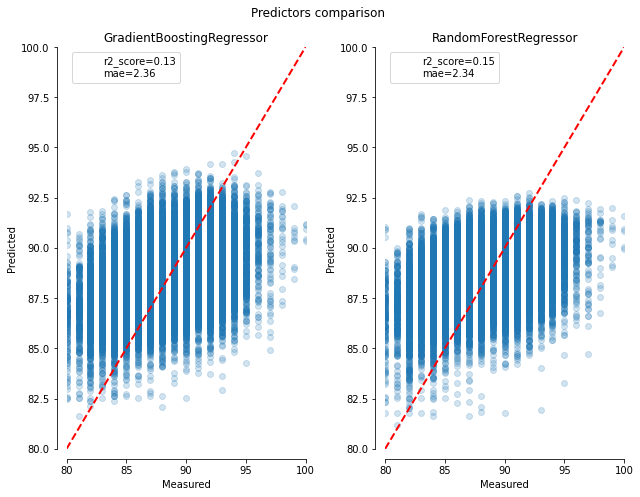

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(9, 7))
axs = np.ravel(axs)

for ax, name in zip(axs, list(estimators.keys())):
    
    plot_regression_results(
        ax, y_real, estimators[name]['y_predict'],
        name,
        (r'r2_score={:.2f}' + '\n' + r'mae={:.2f}')
        .format(estimators[name]['r2_score'],
                estimators[name]['mae']))

plt.suptitle('Predictors comparison ')
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

### Conclusion

- Both predictors show very poor performance on input dataset for TF-IDF feature encoding. 

- Mean absolute error is to big approximately 2.3 for both models. It's about 11.5% average error.

- r2_score is near zero so our models does not explain any of the variation in the response variable around its mean.